In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import datetime as dt
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

In [5]:
# Tickers
tickers = ['^GSPC', '^VIX', '^TNX', 'EURUSD=X', 'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'GBPUSD=X', 'NFLX']

# dates
startdate = '2015-1-1'
train_end = '2017-12-31'
test_start = '2018-01-01'
enddate = '2018-12-31'

# data Close
data_close = pdr.get_data_yahoo(tickers, start=startdate, end=enddate)['Adj Close']
print('\n--- Full dataset')
# display(data_close)

# data returns
data = data_close.shift(1) / data_close - 1
print('\n--- Full dataset returns')
# display(data)

# Sets
data_train = data[startdate:train_end].dropna()
data_test = data[test_start:enddate].dropna()
print('\n--- Train set unadjusted')
# display(data_train)
print('\n--- Test set unadjusted')
# display(data_test)

# mu sigma train
mu_train = data_train.mean()
sigma_train = data_train.std()
print('\n--- mu train:')
# display(pd.DataFrame(mu_train, columns=['Train set Mean']))
print('\n--- sigma train:')
# display(pd.DataFrame(sigma_train, columns=['Train set st dev']))

# Final sets
data_train_prod = (data_train - mu_train) / sigma_train
data_test_prod = (data_test - mu_train) / sigma_train
print('\n--- Train set adjusted')
# display(data_train_prod)
print('\n--- Test set adjusted')
# display(data_test_prod)

[*********************100%***********************]  9 of 9 completed

--- Full dataset

--- Full dataset returns

--- Train set unadjusted

--- Test set unadjusted

--- mu train:

--- sigma train:

--- Train set adjusted

--- Test set adjusted


In [6]:
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(data_train_prod['^GSPC'])

In [7]:
data_train_prod.columns

Index(['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X', 'NFLX',
       '^GSPC', '^TNX', '^VIX'],
      dtype='object')

In [8]:
win_length = 2 ** (4-1) * 2 * 4
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
train_gen_df = data_train_prod['^GSPC']
test_gen_df = data_test_prod['^GSPC']
train_data_gen = TimeseriesGenerator(train_gen_df.values, train_gen_df, length=win_length)
test_data_gen = TimeseriesGenerator(test_gen_df.values, test_gen_df, length=win_length)
train_data_gen

## Wavenet

In [9]:
# https://github.com/usernaamee/keras-wavenet/blob/master/simple-generative-model.py

In [10]:
from tensorflow.keras.layers import Convolution1D, Convolution2D, Flatten, Dense, \
    Input, Lambda, Activation, BatchNormalization, Dropout
from tensorflow import keras
import tensorflow

def WaveNetBlock(filters, kernel_size, dilation_rate, activation=None):
    def f(input_):
        residual = input_
        tanh_out = Convolution1D(filters, kernel_size,
                                       dilation_rate=dilation_rate,
                                       padding='same',
                                       activation='tanh')(input_)
        sigmoid_out = Convolution1D(filters, kernel_size,
                                          dilation_rate=dilation_rate,
                                          padding='same',
                                          activation='relu')(input_)
        merged = keras.layers.Multiply()([tanh_out, sigmoid_out])
        skip_out = Convolution1D(1, 1, activation=activation, padding='same')(merged)
        out = keras.layers.Add()([skip_out, residual])
        return out, skip_out
#         return skip_out
    return f


# def WaveNetBlock(filters, kernel_size, dilation_rate, activation=None):
#     def f(input_):
#         residual = input_
#         conv = Convolution1D(filters, kernel_size,
#                                        dilation_rate=dilation_rate,
#                                        padding='same',
#                                        activation='relu')(input_)
#         if residual.shape[-1] != filters:
#             residual = Convolution1D(filters, 1, activation=activation, padding='same')(residual)
#         out = keras.layers.Add()([conv, residual])
#         out = Activation('relu')(out)
#         return out, conv
#     return f

In [11]:
def evaluate_model(model, hist):
    total_mae = mean_absolute_error(train_gen_df[win_length:], np.zeros_like(train_gen_df[win_length:]))
    model_mae = mean_absolute_error(np.squeeze(model.predict(train_data_gen)), train_gen_df[win_length:]) 
    print(f'train MAE: {model_mae: 0.4f} ({model_mae/total_mae: 0.2%}), total={total_mae: 0.4f}')
    total_mae = mean_absolute_error(test_gen_df[win_length:], np.zeros_like(test_gen_df[win_length:]))
    model_mae = mean_absolute_error(np.squeeze(model.predict(test_data_gen)), test_gen_df[win_length:]) 
    print(f'test MAE: {model_mae: 0.4f} ({model_mae/total_mae: 0.2%}), total={total_mae: 0.4f}')
    plt.scatter(np.squeeze(model.predict(train_data_gen)), train_gen_df[win_length:])
    plt.title('training')
    plt.xlabel('prediction')
    plt.subplots()
    plt.scatter(np.squeeze(model.predict(test_data_gen)), test_gen_df[win_length:])
    plt.title('testing')
    plt.xlabel('prediction')
    pd.DataFrame(hist.history).plot()

Simple Dilated Covnet, filter=1, kernel=1

In [12]:
def conv_one():
    x = i = Input(shape=(win_length, 1))
    x = BatchNormalization()(x)
    x = Convolution1D(filters=1, kernel_size=2, dilation_rate=2**0, padding='same', activation='relu')(x)
    x = Convolution1D(filters=1, kernel_size=2, dilation_rate=2**1, padding='same', activation='relu')(x)
    x = Convolution1D(filters=1, kernel_size=2, dilation_rate=2**2, padding='same', activation='relu')(x)
    x = Convolution1D(filters=1, kernel_size=2, dilation_rate=2**3, padding='same', activation='relu')(x)
    
    x = Convolution1D(filters=1, kernel_size=1, dilation_rate=1, padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(1, activation='linear', kernel_regularizer='l2')(x)
    model = keras.Model(i, x)
    return model

In [13]:
def wave_one():
    x = i = Input(shape=(win_length, 1))
    x = BatchNormalization()(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**0, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**1, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**2, activation='relu')(x)
    x, _ = WaveNetBlock(filters=1, kernel_size=2, dilation_rate=2**3, activation='relu')(x)

    x = Convolution1D(filters=1, kernel_size=1, dilation_rate=1, padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(1, activation='linear', kernel_regularizer='l2')(x)
    model = keras.Model(i, x)
    return model

In [14]:
def conv_multi_extra_layer():
    x = i = Input(shape=(win_length, 1))
    x = BatchNormalization()(x)
    x = Convolution1D(filters=4,  kernel_size=2, dilation_rate=2**0, padding='same', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Convolution1D(filters=8,  kernel_size=2, dilation_rate=2**1, padding='same', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Convolution1D(filters=16, kernel_size=2, dilation_rate=2**2, padding='same', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Convolution1D(filters=32, kernel_size=2, dilation_rate=2**3, padding='same', activation='relu')(x)
    x = Dropout(0.1)(x)

    x = Convolution1D(filters=1, kernel_size=1, dilation_rate=1, padding='same', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Flatten()(x)
    x = Dense(win_length, activation='relu', kernel_regularizer='l2')(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation='linear', kernel_regularizer='l2')(x)
    x = Dropout(0.1)(x)
    model = keras.Model(i, x)
    return model

In [15]:
def wave_multi_extra_layer():
    x = i = Input(shape=(win_length, 1))
    x = BatchNormalization()(x)
    x, _ = WaveNetBlock(filters=3, kernel_size=2, dilation_rate=2**0, activation='relu')(x)
    x, _ = WaveNetBlock(filters=3, kernel_size=2, dilation_rate=2**1, activation='relu')(x)
    x, _ = WaveNetBlock(filters=3, kernel_size=2, dilation_rate=2**2, activation='relu')(x)
    x, _ = WaveNetBlock(filters=3, kernel_size=2, dilation_rate=2**3, activation='relu')(x)

    x = Convolution1D(filters=1, kernel_size=1, dilation_rate=1, padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(1, activation='linear')(x)
    model = keras.Model(i, x)
    return model

In [16]:
make_tensorboard_callback = lambda key: keras.callbacks.TensorBoard(log_dir=f"logs/fit/{key}/" + pd.to_datetime('now').strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

In [17]:
# model = conv_one()
# model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
# hist = model.fit(train_data_gen, epochs=100, validation_data=test_data_gen, verbose=0, callbacks=[make_tensorboard_callback('conv_one')])
# evaluate_model(model, hist)
# hist

Wavenet, filter=1, kernel=1

train MAE:  0.6488 ( 98.30%), total= 0.6600
test MAE:  0.9273 ( 114.21%), total= 0.8119


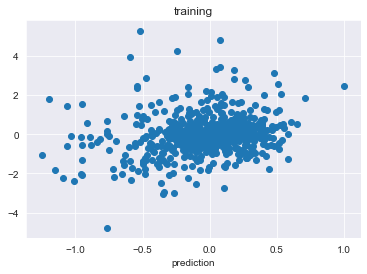

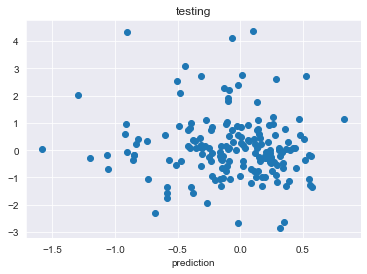

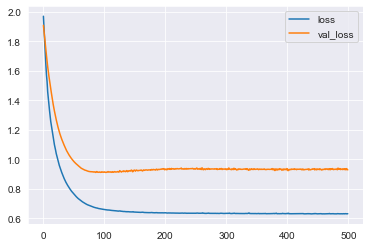

In [18]:
model1 = wave_one()
model1.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model1.fit(train_data_gen, epochs=500, validation_data=test_data_gen, verbose=0, callbacks=[make_tensorboard_callback('wave_one')])
evaluate_model(model1, hist)
hist

ConvNet, variable filters / kernel_size

In [19]:
# model = conv_multi_extra_layer()
# model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
# hist = model.fit(train_data_gen, epochs=100, validation_data=test_data_gen, verbose=0, callbacks=[make_tensorboard_callback('conv_multi_extra_layer')])
# evaluate_model(model, hist)
# hist

WaveNet, variable filter/kernel

train MAE:  0.6245 ( 94.62%), total= 0.6600
test MAE:  0.8772 ( 108.04%), total= 0.8119


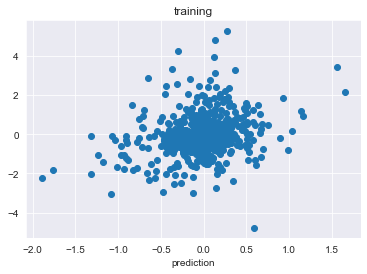

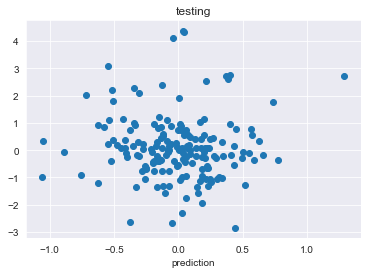

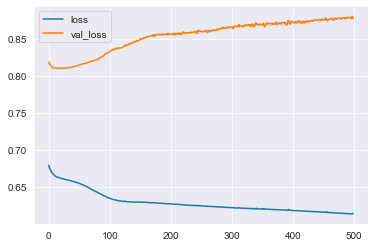

In [20]:
model = wave_multi_extra_layer()
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=500, validation_data=test_data_gen, verbose=0, callbacks=[make_tensorboard_callback('wave_multi_extra_layer')])
evaluate_model(model, hist)
hist

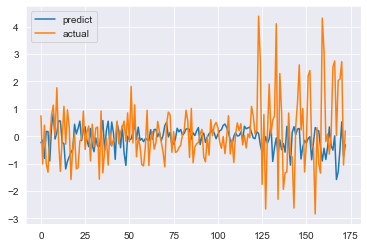

In [27]:
pd.DataFrame(np.vstack([np.squeeze(model1.predict(test_data_gen)), test_gen_df[win_length:]]), index=['predict' , 'actual']).T.plot()

In [33]:
(pd.DataFrame(np.vstack([np.squeeze(model1.predict(test_data_gen)), test_gen_df[win_length:]]), index=['predict' , 'actual']).T.apply(np.sign).sum(axis=1)==0).value_counts()

True     93
False    80
dtype: int64

In [34]:
93 / 173

0.5375722543352601

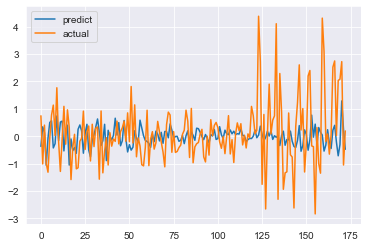

In [26]:
pd.DataFrame(np.vstack([np.squeeze(model.predict(test_data_gen)), test_gen_df[win_length:]]), index=['predict' , 'actual']).T.plot()

In [36]:
(pd.DataFrame(np.vstack([np.squeeze(model.predict(test_data_gen)), test_gen_df[win_length:]]), index=['predict' , 'actual']).T.apply(np.sign).sum(axis=1)==0).value_counts()

True     90
False    83
dtype: int64

In [21]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 10832), started 2:29:41 ago. (Use '!kill 10832' to kill it.)